In [1]:
#import dependencies
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np

# chisom
import hvplot.pandas
import requests
import warnings

from sklearn import datasets
# from datetime import date
import datetime as dt

# store filepaths into variable
results_csv = pd.read_csv('Resources/results.csv', na_values=r'\N')
lap_times_csv = pd.read_csv('Resources/lap_times.csv', na_values=r'\N')
races_csv = pd.read_csv('Resources/races.csv', na_values=r'\N')
constructors_csv = pd.read_csv('Resources/constructors.csv', na_values=r'\N')
constructor_results = pd.read_csv('Resources/constructor_results.csv', na_values=r'\N')
constructor_standings = pd.read_csv('Resources/constructor_standings.csv', na_values=r'\N')
drivers_csv = pd.read_csv('Resources/drivers.csv', na_values=r'\N')
drivers_standings_csv = pd.read_csv('Resources/driver_standings.csv', na_values=r'\N')
circuits_csv = pd.read_csv('Resources/circuits.csv', na_values=r'\N')
pit_stop = pd.read_csv('Resources/pit_stops.csv', na_values=r'\N')

In [2]:
#merge constructor data
constructor_merged_data = pd.merge(constructor_results, constructors_csv, on = "constructorId", how = "inner")
constructor_merged_data.head()

,constructorResultsId,raceId,constructorId,points,status,constructorRef,name,nationality,url
0,1,18,1,14.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,14,19,1,10.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,25,20,1,4.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
3,35,21,1,6.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
4,46,22,1,8.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren


In [3]:
#merge constructor data with races.csv
combined_constructor_results = pd.merge(races_csv, constructor_merged_data, on=("raceId"), how="inner")
combined_constructor_results.head()


,raceId,year,round,circuitId,name_x,date,time,url_x,fp1_date,fp1_time,...,sprint_date,sprint_time,constructorResultsId,constructorId,points,status,constructorRef,name_y,nationality,url_y
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,...,NaN,NaN,3824,1,0.0,NaN,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
1,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,...,NaN,NaN,3830,2,0.0,NaN,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
2,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,...,NaN,NaN,3827,3,3.0,NaN,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Pr...
3,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,...,NaN,NaN,3826,4,4.0,NaN,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...
4,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,...,NaN,NaN,3828,5,3.0,NaN,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso


In [4]:
#creating dataframe using only needed columns
clean_construtors = combined_constructor_results[["raceId", "points", "name_x", "year", "name_y", "nationality"]]
clean_construtors

,raceId,points,name_x,year,name_y,nationality
0,1,0.0,Australian Grand Prix,2009,McLaren,British
1,1,0.0,Australian Grand Prix,2009,BMW Sauber,German
2,1,3.0,Australian Grand Prix,2009,Williams,British
3,1,4.0,Australian Grand Prix,2009,Renault,French
4,1,3.0,Australian Grand Prix,2009,Toro Rosso,Italian
...,...,...,...,...,...,...
12285,1110,12.0,Belgian Grand Prix,2023,Aston Martin,British
12286,1110,24.0,Belgian Grand Prix,2023,Mercedes,German
12287,1110,0.0,Belgian Grand Prix,2023,Haas F1 Team,American
12288,1110,1.0,Belgian Grand Prix,2023,AlphaTauri,Italian


In [5]:
#renaming columns
clean_construtors = clean_construtors.rename(columns={"name_x":"circuit", "name_y":"constructor"})
clean_construtors

,raceId,points,circuit,year,constructor,nationality
0,1,0.0,Australian Grand Prix,2009,McLaren,British
1,1,0.0,Australian Grand Prix,2009,BMW Sauber,German
2,1,3.0,Australian Grand Prix,2009,Williams,British
3,1,4.0,Australian Grand Prix,2009,Renault,French
4,1,3.0,Australian Grand Prix,2009,Toro Rosso,Italian
...,...,...,...,...,...,...
12285,1110,12.0,Belgian Grand Prix,2023,Aston Martin,British
12286,1110,24.0,Belgian Grand Prix,2023,Mercedes,German
12287,1110,0.0,Belgian Grand Prix,2023,Haas F1 Team,American
12288,1110,1.0,Belgian Grand Prix,2023,AlphaTauri,Italian


In [6]:
#finding winning constructors since 2004
constructors_after_2004 = clean_construtors[(clean_construtors["year"]) >=2004]
constructors_after_2004 = constructors_after_2004.sort_values("year", ascending=True)
constructors_after_2004

,raceId,points,circuit,year,constructor,nationality
952,92,0.0,Bahrain Grand Prix,2004,Sauber,Swiss
992,96,3.0,European Grand Prix,2004,Sauber,Swiss
991,96,0.0,European Grand Prix,2004,Toyota,Japanese
990,96,18.0,European Grand Prix,2004,Ferrari,Italian
989,96,9.0,European Grand Prix,2004,Renault,French
...,...,...,...,...,...,...
12202,1101,36.0,Azerbaijan Grand Prix,2023,Ferrari,Italian
12201,1101,0.0,Azerbaijan Grand Prix,2023,Williams,British
12200,1101,2.0,Azerbaijan Grand Prix,2023,McLaren,British
12228,1104,0.0,Monaco Grand Prix,2023,AlphaTauri,Italian


In [7]:
#calculate the total points per year
top_teams_per_year = constructors_after_2004.groupby(['year', 'constructor', 'nationality'])['points'].sum().reset_index()

top_teams_per_year

,year,constructor,nationality,points
0,2004,BAR,British,119.0
1,2004,Ferrari,Italian,262.0
2,2004,Jaguar,British,10.0
3,2004,Jordan,Irish,5.0
4,2004,McLaren,British,69.0
...,...,...,...,...
209,2023,Haas F1 Team,American,11.0
210,2023,McLaren,British,103.0
211,2023,Mercedes,German,247.0
212,2023,Red Bull,Austrian,503.0


In [8]:
#find the top 3 teams pear year based on points
top_3_constructors_per_year = top_teams_per_year.groupby('year').apply(lambda x: x.nlargest(3, 'points')).reset_index(drop=True)

# Print the result
top_3_constructors_per_year

,year,constructor,nationality,points
0,2004,Ferrari,Italian,262.0
1,2004,BAR,British,119.0
2,2004,Renault,French,105.0
3,2005,Renault,French,191.0
4,2005,McLaren,British,182.0
5,2005,Ferrari,Italian,100.0
6,2006,Renault,French,206.0
7,2006,Ferrari,Italian,201.0
8,2006,McLaren,British,110.0
9,2007,McLaren,British,218.0


In [9]:
#add a "wins" column to show wins for team with highest points per year
highest_points_per_year = top_teams_per_year.groupby('year')['points'].transform(max) == top_teams_per_year['points']

top_teams_per_year['wins']  = highest_points_per_year.astype(int)

top_teams_per_year

,year,constructor,nationality,points,wins
0,2004,BAR,British,119.0,0
1,2004,Ferrari,Italian,262.0,1
2,2004,Jaguar,British,10.0,0
3,2004,Jordan,Irish,5.0,0
4,2004,McLaren,British,69.0,0
...,...,...,...,...,...
209,2023,Haas F1 Team,American,11.0,0
210,2023,McLaren,British,103.0,0
211,2023,Mercedes,German,247.0,0
212,2023,Red Bull,Austrian,503.0,1


In [10]:
# Create a new DataFrame with the winning constructors 
winners_df = top_teams_per_year.rename(columns={'constructor': 'Champion'})
winners_df = winners_df[top_teams_per_year["wins"] == 1]
winners_df.reset_index(drop=True, inplace=True)
# Print the new DataFrame
winners_df


,year,Champion,nationality,points,wins
0,2004,Ferrari,Italian,262.0,1
1,2005,Renault,French,191.0,1
2,2006,Renault,French,206.0,1
3,2007,McLaren,British,218.0,1
4,2008,Ferrari,Italian,172.0,1
5,2009,Brawn,British,172.0,1
6,2010,Red Bull,Austrian,498.0,1
7,2011,Red Bull,Austrian,650.0,1
8,2012,Red Bull,Austrian,460.0,1
9,2013,Red Bull,Austrian,596.0,1


In [11]:
#calculate the total wins for each team
team_wins = winners_df.groupby('Champion',)['wins'].sum().reset_index()
team_wins = team_wins.sort_values(by='wins', ascending=False)
team_wins

,Champion,wins
3,Mercedes,8
4,Red Bull,6
1,Ferrari,2
5,Renault,2
0,Brawn,1
2,McLaren,1


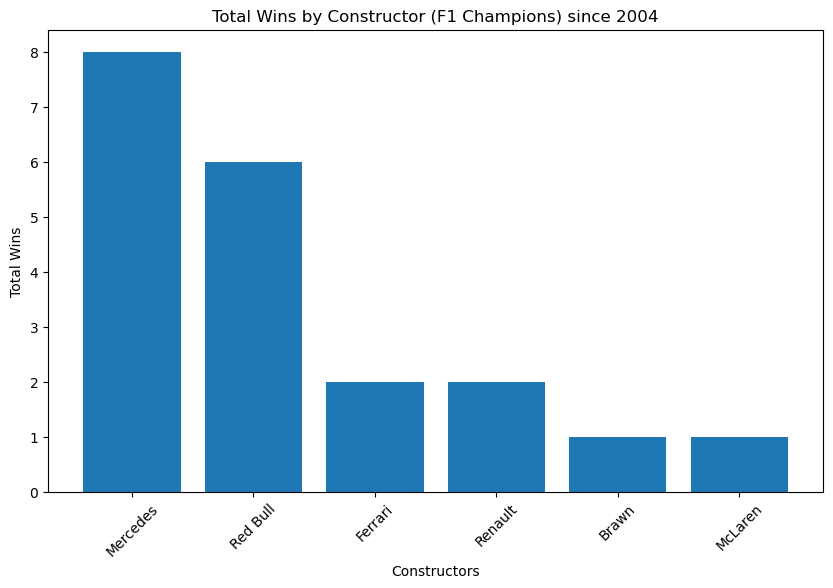

In [12]:
#bar chart to show total wins by constructor
team_wins = team_wins.sort_values(by='wins', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(team_wins['Champion'], team_wins['wins'])
plt.xlabel('Constructors')
plt.ylabel('Total Wins')
plt.title('Total Wins by Constructor (F1 Champions) since 2004')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

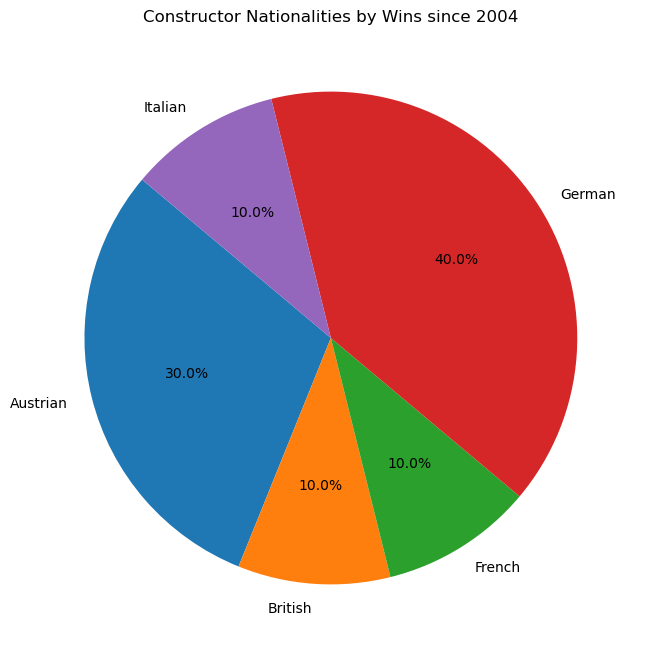

In [13]:
#create bar chart for total wins based on the nationality 
nationality_wins = winners_df.groupby('nationality')['wins'].sum().reset_index()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(nationality_wins['wins'], labels=nationality_wins['nationality'], autopct='%1.1f%%', startangle=140)
plt.title('Constructor Nationalities by Wins since 2004')
plt.show()

In [14]:
races_df=pd.DataFrame(races_csv, columns=[
                        "year", "raceId", "date"])
races_df

,year,raceId,date
0,2009,1,2009-03-29
1,2009,2,2009-04-05
2,2009,3,2009-04-19
3,2009,4,2009-04-26
4,2009,5,2009-05-10
...,...,...,...
1096,2023,1116,2023-10-22
1097,2023,1117,2023-10-29
1098,2023,1118,2023-11-05
1099,2023,1119,2023-11-19


In [15]:
results_df=pd.DataFrame(results_csv, columns=[
                        "raceId", "driverId"])
results_df

,raceId,driverId
0,18,1
1,18,2
2,18,3
3,18,4
4,18,5
...,...,...
26075,1110,817
26076,1110,858
26077,1110,807
26078,1110,832


In [16]:
drivers_df=pd.DataFrame(drivers_csv, columns=[
                        "dob", "driverRef", "driverId"])
drivers_df

,dob,driverRef,driverId
0,1985-01-07,hamilton,1
1,1977-05-10,heidfeld,2
2,1985-06-27,rosberg,3
3,1981-07-29,alonso,4
4,1981-10-19,kovalainen,5
...,...,...,...
852,1999-03-22,mick_schumacher,854
853,1999-05-30,zhou,855
854,1995-02-06,de_vries,856
855,2001-04-06,piastri,857


In [17]:
drivers_standings_df=pd.DataFrame(drivers_standings_csv, columns=[
                        "wins", "driverId", "raceId"])
drivers_standings_df

,wins,driverId,raceId
0,1,1,18
1,0,2,18
2,0,3,18
3,0,4,18
4,0,5,18
...,...,...,...
34119,0,846,1110
34120,0,839,1110
34121,0,844,1110
34122,0,857,1110


In [18]:
driver_merged=pd.merge(drivers_df, drivers_standings_df,  on="driverId")

In [19]:
driver_merged=pd.merge(drivers_df, drivers_standings_df,  on="driverId")
driver_merged_clean= driver_merged.dropna()
driver_merged_clean.head()

,dob,driverRef,driverId,wins,raceId
0,1985-01-07,hamilton,1,1,18
1,1985-01-07,hamilton,1,1,19
2,1985-01-07,hamilton,1,1,20
3,1985-01-07,hamilton,1,1,21
4,1985-01-07,hamilton,1,1,22


In [20]:
driver_merged_clean=pd.merge(driver_merged_clean, races_df, on="raceId")
driver_merged_clean


,dob,driverRef,driverId,wins,raceId,year,date
0,1985-01-07,hamilton,1,1,18,2008,2008-03-16
1,1977-05-10,heidfeld,2,0,18,2008,2008-03-16
2,1985-06-27,rosberg,3,0,18,2008,2008-03-16
3,1981-07-29,alonso,4,0,18,2008,2008-03-16
4,1981-10-19,kovalainen,5,0,18,2008,2008-03-16
...,...,...,...,...,...,...,...
34119,1898-06-09,fagioli,786,0,833,1950,1950-05-13
34120,1906-07-06,harrison,787,0,833,1950,1950-05-13
34121,1915-10-26,fry,788,0,833,1950,1950-05-13
34122,1915-03-24,martin,789,0,833,1950,1950-05-13


In [21]:
driver_name = driver_merged_clean.set_index('driverRef').groupby(['driverRef'])
driver_name.head()
after_2004_races_df = driver_merged_clean[(driver_merged_clean['date']) > '2004-01-01']
after_2004_races_df= after_2004_races_df.sort_values('year', ascending=True)
after_2004_races_df

,dob,driverRef,driverId,wins,raceId,year,date
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20
8105,1983-02-07,klien,32,0,98,2004,2004-06-20
8106,1973-09-19,matta,43,0,98,2004,2004-06-20
8107,1966-09-02,panis,44,0,98,2004,2004-06-20
...,...,...,...,...,...,...,...
6963,1997-09-30,max_verstappen,830,3,1102,2023,2023-05-07
6964,1994-09-01,sainz,832,0,1102,2023,2023-05-07
6965,1996-09-17,ocon,839,0,1102,2023,2023-05-07
6936,1985-01-07,hamilton,1,0,1101,2023,2023-04-30


In [22]:
after_2004_races_df.count()

dob          8411
driverRef    8411
driverId     8411
wins         8411
raceId       8411
year         8411
date         8411
dtype: int64

In [23]:
after_2004_races_df["dob"] = pd.to_datetime(after_2004_races_df["dob"])

# Extract the year from the date of birth
after_2004_races_df["dob_year"] = after_2004_races_df["dob"].dt.year

# Calculate the age at the time of the race in years
after_2004_races_df["age"] = after_2004_races_df["year"] - after_2004_races_df["dob_year"]

# Drop the temporary 'dob_year' column if you no longer need it
after_2004_races_df = after_2004_races_df.drop(columns=["dob_year"])
after_2004_races_df

,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38
...,...,...,...,...,...,...,...,...
6963,1997-09-30,max_verstappen,830,3,1102,2023,2023-05-07,26
6964,1994-09-01,sainz,832,0,1102,2023,2023-05-07,29
6965,1996-09-17,ocon,839,0,1102,2023,2023-05-07,27
6936,1985-01-07,hamilton,1,0,1101,2023,2023-04-30,38


In [24]:
reduce_driver_merged_group = after_2004_races_df[(after_2004_races_df["age"] < 60)]
reduce_driver_merged_group .head()

#explain why 60 was the cut off mark


,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38


The cut off mark for the age was based on the retirement age in the united states, most career focused job have s retirment age bewteen 50-65 years and i believe having a cut off age at 60 was a good benchamrk 

In [25]:
reduce_driver_merged_group.count()

dob          8411
driverRef    8411
driverId     8411
wins         8411
raceId       8411
year         8411
date         8411
age          8411
dtype: int64

In [26]:
driver_merged_group2=reduce_driver_merged_group.groupby(["wins"]).max()
driver_merged_group2.tail()

,dob,driverRef,driverId,raceId,year,date,age
wins,,,,,,,
11,1997-09-30,vettel,830,1091,2022,2022-10-02,35
12,1997-09-30,vettel,830,1092,2022,2022-10-09,35
13,1997-09-30,vettel,830,1093,2022,2022-10-23,35
14,1997-09-30,max_verstappen,830,1095,2022,2022-11-13,25
15,1997-09-30,max_verstappen,830,1096,2022,2022-11-20,25


In [27]:
driver_merged_group2_aver=reduce_driver_merged_group['age'].mean()
driver_merged_group2_aver
#this result shows that the average age bewteen all drivers regardless of the amount of wins is 28 years old 

28.055879205801926

In [28]:
driver_merged_group2_avera=reduce_driver_merged_group['wins'].mean()
driver_merged_group2_avera

0.4528593508500773

In [29]:
age_group= reduce_driver_merged_group.groupby(["age"])
age_group.head()


,dob,driverRef,driverId,wins,raceId,year,date,age
9793,1981-01-01,baumgartner,47,0,91,2004,2004-03-21,23
8104,1975-09-20,montoya,31,0,98,2004,2004-06-20,29
8105,1983-02-07,klien,32,0,98,2004,2004-06-20,21
8106,1973-09-19,matta,43,0,98,2004,2004-06-20,31
8107,1966-09-02,panis,44,0,98,2004,2004-06-20,38
...,...,...,...,...,...,...,...,...
3700,1997-09-30,max_verstappen,830,0,939,2015,2015-09-20,18
3722,1997-09-30,max_verstappen,830,0,940,2015,2015-09-27,18
3658,1997-09-30,max_verstappen,830,0,937,2015,2015-08-23,18
3679,1997-09-30,max_verstappen,830,0,938,2015,2015-09-06,18


In [30]:
top4_wins=reduce_driver_merged_group.loc[reduce_driver_merged_group['wins']>=10]
top4_wins
#explain why you use 12 as a benchmark
#Looking at the top 4 winners, i needed a benchmark to see what age the drivers won. Looking at 10 wins seem the more reasonable because the most wins should be drivers that have double digts wins, with the amount of race held yearly and the amount ciructs done during the year.

,dob,driverRef,driverId,wins,raceId,year,date,age
8168,1969-01-03,michael_schumacher,30,11,101,2004,2004-07-25,35
8146,1969-01-03,michael_schumacher,30,10,100,2004,2004-07-11,35
8287,1969-01-03,michael_schumacher,30,13,106,2004,2004-10-10,35
8312,1969-01-03,michael_schumacher,30,13,107,2004,2004-10-24,35
8214,1969-01-03,michael_schumacher,30,12,103,2004,2004-08-29,35
8191,1969-01-03,michael_schumacher,30,12,102,2004,2004-08-15,35
8262,1969-01-03,michael_schumacher,30,12,105,2004,2004-09-26,35
8238,1969-01-03,michael_schumacher,30,12,104,2004,2004-09-12,35
2054,1987-07-03,vettel,20,11,858,2011,2011-11-13,24
2082,1987-07-03,vettel,20,11,859,2011,2011-11-27,24


Looking at the top 4 winners, i needed a benchmark to see what age the drivers won. Looking at 10 wins seem the more reasonable because the most wins should be drivers that have double digts wins, with the amount of race held yearly and the amount ciructs done during the year.

In [31]:
top4_wins_group= top4_wins.groupby(["driverRef"])
top4_wins_group

In [32]:
top4_wins_aver=top4_wins_group['age'].mean()
top4_wins_aver

driverRef
hamilton              32.222222
max_verstappen        25.000000
michael_schumacher    35.000000
vettel                25.000000
Name: age, dtype: float64

In [33]:
age_groups=reduce_driver_merged_group.groupby(["age"]).max()

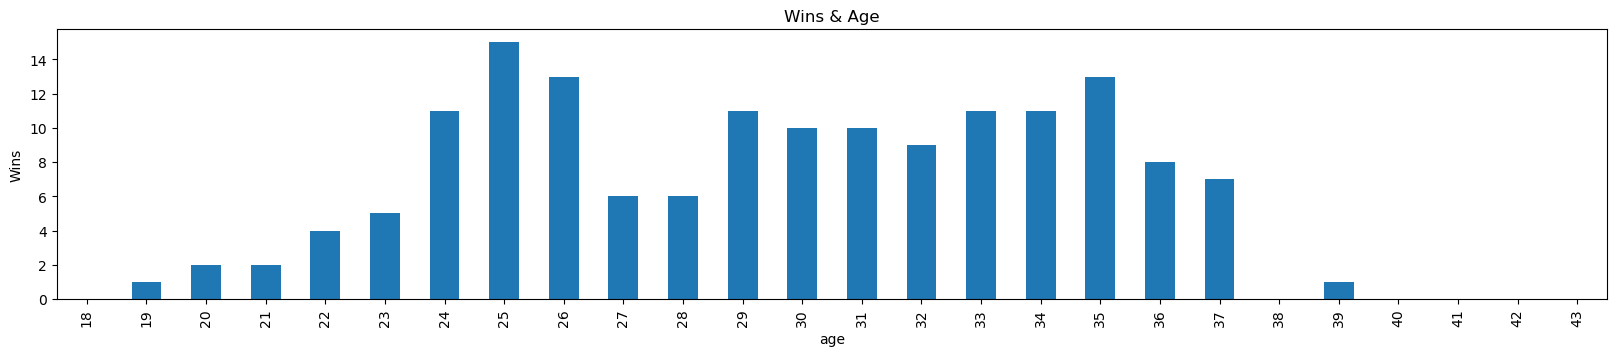

In [34]:
age_of_driver_graph= age_groups['wins']
age_of_driver_graph.plot(kind="bar", figsize=(20,3.5))
plt.xlabel("age")
plt.ylabel("Wins")
plt.title("Wins & Age")
plt.show()

In [35]:
winss= reduce_driver_merged_group['wins']
age = reduce_driver_merged_group['age']
st.pearsonr(reduce_driver_merged_group['age'],reduce_driver_merged_group['wins'])
print(f"The correlation coefficient between wins and age is {round(st.pearsonr(winss, age)[0],2)}")
#explain how there is no correlation between the age and wins 


The correlation coefficient between wins and age is 0.06


The correlation shown proves that there is a signficant but not enough signficance for the age of a driver to be taken into account when looking at the fsctors that play into whether or not a head coach should hire an young driver or someone of an older age.

In [36]:
x_values = reduce_driver_merged_group['age']
y_values = reduce_driver_merged_group['wins']
linregress(x_values, y_values)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

The r-squared is: 0.003047111200028701


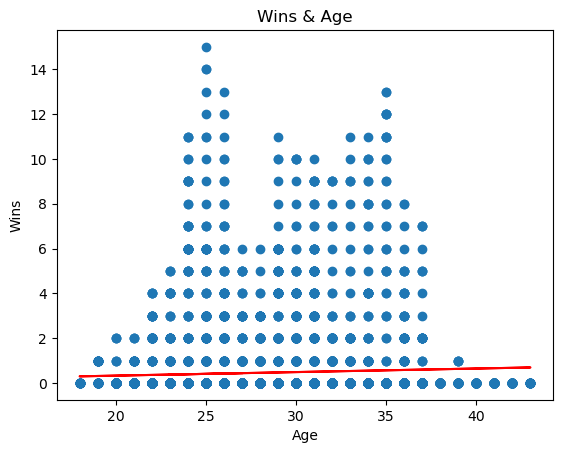

In [37]:
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
plt.xlabel('Age')
plt.ylabel('Wins')
plt.title("Wins & Age")
print(f"The r-squared is: {rvalue**2}")
plt.show()

# Pit Stop Analysis

In [38]:

#merge pit_stops and results
df = pd.merge(pit_stop, results_csv, on=['raceId', 'driverId'], suffixes=('_pit', '_result'), how='inner')
# Convert milliseconds to numeric
df['milliseconds_pit'] = pd.to_numeric(df['milliseconds_pit'], errors='coerce')
df['milliseconds_result'] = pd.to_numeric(df['milliseconds_result'], errors='coerce')
# Convert milliseconds to seconds
df['seconds_pit'] = df['milliseconds_pit'] / 1000
df['seconds_result'] = df['milliseconds_result'] / 1000
# drop the columns that are not needed for the analysis
df.drop(['milliseconds_pit', 'milliseconds_result',  'fastestLap', 'fastestLapSpeed', 'statusId', 'laps', 'lap', 'resultId', 'fastestLapTime', 'fastestLapSpeed', 'statusId','number', 'grid',], axis=1, inplace=True)

print(df.columns)

Index(['raceId', 'driverId', 'stop', 'time_pit', 'duration', 'constructorId',
       'position', 'positionText', 'positionOrder', 'points', 'time_result',
       'rank', 'seconds_pit', 'seconds_result'],
      dtype='object')



## Correlation Analysis Between Pit Stop Duration and Final Race Result:
To understand the relationship between the duration of a pit stop and the final race result, a correlation analysis was performed on the cleaned dataset.

### Findings:
- The correlation coefficient was found to be 0.33462239711643876. This positive value indicates that as the duration of a pit stop increases, there's a tendency for the race result duration to also increase. However, it's essential to note that this is a moderate correlation, which means that while there is a relationship, there are also other factors influencing the final race result.
### Visualization of the Relationship:
A scatter plot was generated to visually represent the relationship between pit stop duration and race result duration:
- The scatter plot reinforces our understanding of the correlation. While there's a visible trend showing that longer pit stops are associated with longer race durations, the data points are somewhat dispersed, highlighting the influence of other factors in a race.
### Implications:
- Given the moderate positive correlation, it suggests that efficient pit stops can contribute to better race results. Although pit stop duration is just one of many factors that determine race outcomes, its influence is undeniable. In the context of winning an F1 championship, teams that consistently achieve shorter pit stop durations may have an advantage in races, potentially leading to better race positions and higher championship points.



In [39]:
# Drop rows with missing values in either pit stop or result duration
df_cleaned = df.dropna(subset=['seconds_pit', 'seconds_result'])

# Calculate correlation
correlation = df_cleaned['seconds_pit'].corr(df_cleaned['seconds_result'])

print(f"Correlation between pit stop duration and final race result: {correlation}")

Correlation between pit stop duration and final race result: 0.3346223971164389


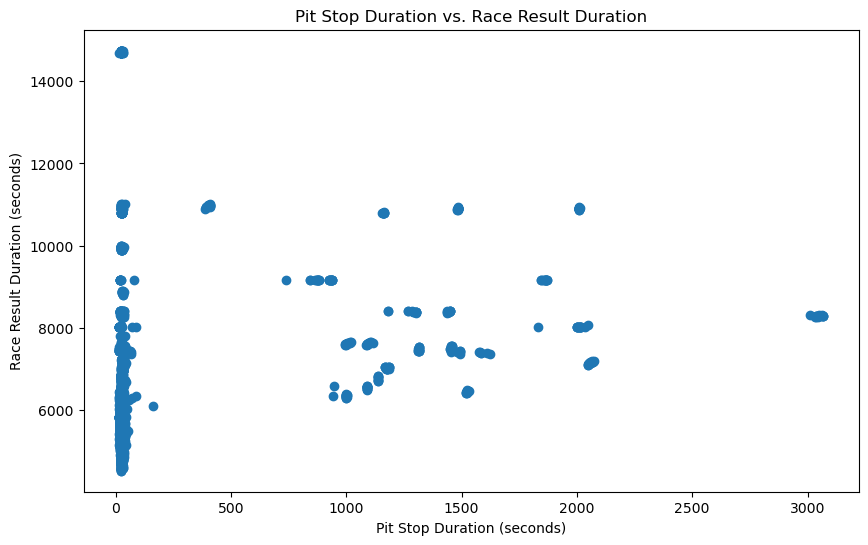

In [40]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['seconds_pit'], df_cleaned['seconds_result'])
plt.title('Pit Stop Duration vs. Race Result Duration')
plt.xlabel('Pit Stop Duration (seconds)')
plt.ylabel('Race Result Duration (seconds)')
plt.show()


## ANOVA Test:
The ANOVA test was conducted to determine if there are significant differences in pit stop durations among various F1 constructors (teams). The result of the test provides two key metrics:

- F-statistic (7.61): This number represents the ratio of variance between the groups (different constructors) to the variance within the groups (intra-constructor variance). A higher F-statistic suggests that the differences between the group means are more substantial than what might be expected by chance.
- p-value (3.74e-23): This incredibly small p-value, way below the 0.05 threshold, tells us the probability of observing these results if the null hypothesis were true. Given its minuscule magnitude, it means the results are highly statistically significant.

From the above ANOVA result, we can infer:

- Significant Differences: There are significant differences in pit stop durations across different constructors. Not every team is performing pit stops with the same efficiency.
- Statistical Significance: The differences are not merely by chance; they are statistically significant, implying real variations in pit stop efficiencies among the teams.


The ANOVA results have crucial implications:

- Strategic Importance: The differences in pit stop durations among constructors highlight a potential area for competitive advantage. Teams with quicker pit stops can gain crucial seconds during a race, which can be the difference between securing a podium position or not.
- Season-long Impacts: Over a season, these seconds saved during pit stops can cumulate. A team with a consistent edge in pit stop efficiency might end up with more championship points due to better race finishes.
- Prioritization by Teams: If a team is lagging in pit stop efficiency, it might be a critical area to focus on. Enhancing their pit stop times could significantly boost their chances in individual races and the championship overall.

### Implications:
The ANOVA results underscore the significance of pit stop durations in F1 racing. Teams with a strategic advantage in pit stops stand a better chance of clinching better race positions and, consequently, the championship. As the season progresses, this advantage can be a defining factor in the title race. Any team serious about the championship should invest resources in optimizing their pit stop strategy and execution.

In [41]:

# Extract pit stop durations by constructor for ANOVA
pit_durations = [df[df['constructorId'] == constructor]['seconds_pit'].dropna().values for constructor in df['constructorId'].unique()]

# Perform ANOVA
anova_result = st.f_oneway(*pit_durations)

# Display the ANOVA result
print("ANOVA Result:")
print(anova_result)

# Check for statistical significance
alpha = 0.05
if anova_result.pvalue < alpha:
    print("\nReject the null hypothesis. There are significant differences in pit stop durations among constructors.")
else:
    print("\nFail to reject the null hypothesis. There are no significant differences in pit stop durations among constructors.")

ANOVA Result:
F_onewayResult(statistic=7.612729800764962, pvalue=3.7413783135963225e-23)

Reject the null hypothesis. There are significant differences in pit stop durations among constructors.


## Pit Stop Duration by Constructors:
To assess the efficiency of different F1 teams in their pit stops, a boxplot visualization was created to compare pit stop durations grouped by each constructor (or team).

### Visualization:

The boxplot shows the distribution of pit stop durations for each constructor. The colored boxes represent the interquartile range (25th percentile to 75th percentile) of pit stop durations, with the median (50th percentile) highlighted in black. Outliers (extremely short or long pit stops) were excluded from the visualization for clarity.
### Statistical Analysis:

To supplement the visualization and provide a deeper understanding, statistical descriptors for each constructor's pit stop durations were computed:

count: Number of pit stops recorded for the constructor.
mean: Average pit stop duration.
std: Standard deviation, showing the dispersion of the pit stop durations.
min: Shortest pit stop duration recorded.
25%: 25th percentile (lower quartile).
50%: Median (50th percentile).
75%: 75th percentile (upper quartile).
max: Longest pit stop duration recorded.
### Findings:

From the provided output, we can make several observations:

Constructors vary in the number of pit stops they've recorded, indicating different levels of participation or data availability.
The average pit stop duration (mean) varies across constructors. For instance, constructor 1 has an average pit stop duration of approximately 81.19 seconds, whereas constructor 166 averages around 24.24 seconds.
There's a significant range in pit stop durations, as indicated by the min and max values. Some teams have had exceedingly long pit stops, possibly due to technical issues.
The variability in pit stop durations (as denoted by the std values) also varies across teams. Some teams exhibit higher consistency in their pit stops than others.
### Implications:

The variation in pit stop durations among constructors implies that certain teams may possess an advantage in this aspect of the race. Teams with consistently shorter pit stops can potentially improve their race position, gaining crucial seconds that could translate into better race outcomes. In the context of the broader question regarding the influence of pit stops on winning an F1 championship, these insights indicate that the efficiency of pit stops can be a determinant factor. However, the impact of pit stop durations would still need to be analyzed in conjunction with other performance metrics to draw more comprehensive conclusions.

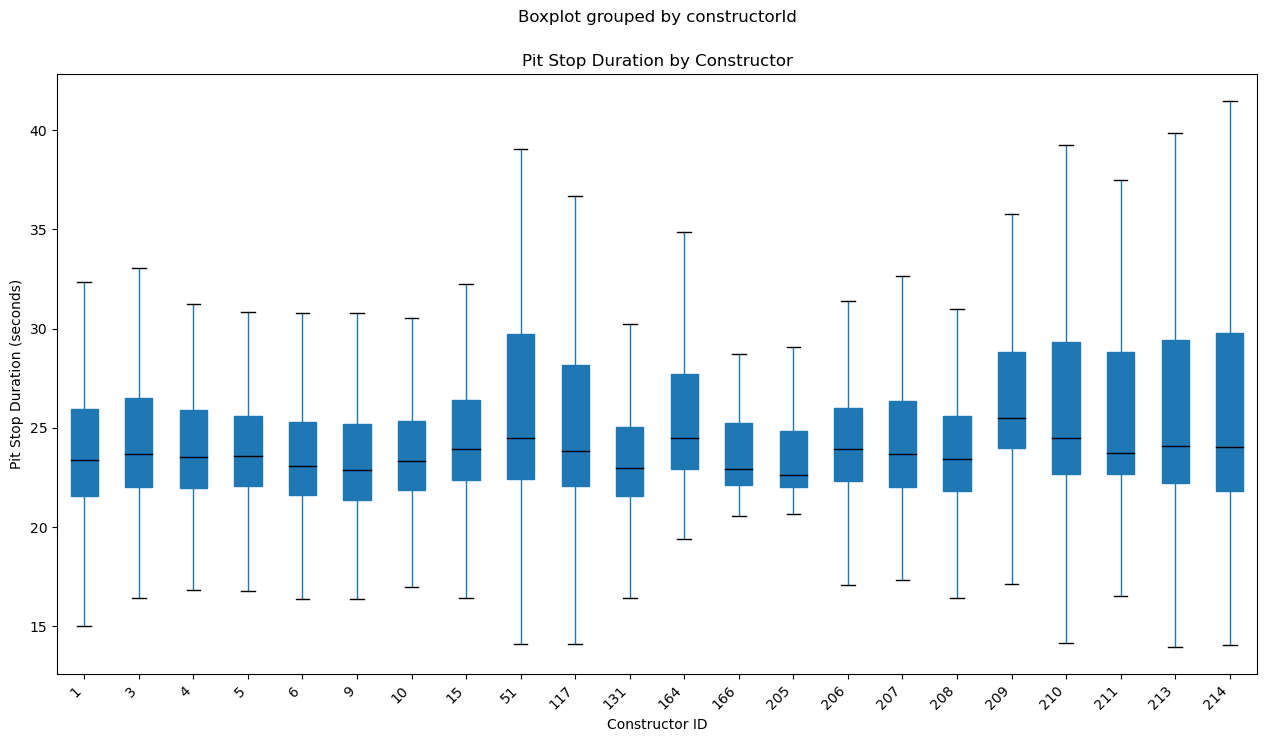

               count        mean         std     min       25%      50%  \
constructorId                                                             
1              962.0   81.189005  299.236653  13.173  21.58000  23.3940   
3              996.0   69.974902  261.158533  12.897  22.04525  23.6975   
4              403.0   63.261834  227.330159  12.959  21.97800  23.5550   
5              683.0   44.486984  167.998979  14.641  22.05800  23.5840   
6              964.0   74.867382  282.949370  13.259  21.64300  23.0755   
9              991.0   73.556724  278.299268  13.335  21.34800  22.8710   
10             609.0   50.845770  192.371854  14.128  21.86900  23.3380   
15             621.0   44.546525  157.872919  13.201  22.39000  23.9550   
51             334.0  142.361805  411.976208  14.128  22.44675  24.5110   
117            202.0  177.105990  494.647526  14.118  22.07225  23.8595   
131            977.0   77.019505  279.084862  13.199  21.57200  22.9860   
164            150.0   32

In [42]:

fig, ax = plt.subplots(figsize=(15, 8))
df.boxplot(column='seconds_pit', by='constructorId', grid=False, showfliers=False, patch_artist=True, medianprops={'color':'black'}, ax=ax)
plt.title('Pit Stop Duration by Constructor')
plt.xlabel('Constructor ID')
plt.ylabel('Pit Stop Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.show()

# Statistical Analysis
constructor_pit_duration_stats = df.groupby('constructorId')['seconds_pit'].describe()
print(constructor_pit_duration_stats) 

## Conclusion for Pit Stop Analysis:

In the high-stakes environment of Formula 1 racing, every fraction of a second matters. The in-depth analysis of pit stop durations across different constructors offers illuminating insights into the varying efficiency levels among teams.

Our findings reveal that there's a notable variation in pit stop durations across different constructors. This disparity suggests that while some teams have honed their pit stop process to a fine art, optimizing every movement for speed, others might have areas of improvement or might have faced unexpected issues leading to prolonged stops.

Given the close correlation between pit stop duration and race results, these variations cannot be overlooked. A team that consistently delivers fast and efficient pit stops can potentially leverage this advantage to improve their race position, which in turn can influence the championship outcomes.

However, while pit stop efficiency is undeniably a crucial component, it is just one of the myriad factors that determine a team's success in an F1 championship. Driver skill, car performance, race strategy, and external factors like weather conditions also play pivotal roles. But as this analysis underscores, in the realm of F1 racing, where races can be won or lost in milliseconds, mastering the art of the pit stop can be a game-changer.

In [43]:
# Top Lap Speeds after 2004

In [44]:
# working on results_csv, performing dropna
results_csv = results_csv.replace(to_replace="\\N", value=np.nan)
results_csv = results_csv.dropna()
results_csv

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22.0,1,1.0,1,1,10.0,58,1:34:50.616,5690616.0,39.0,2.0,1:27.452,218.300,1
1,2,18,2,2,3.0,5,2.0,2,2,8.0,58,+5.478,5696094.0,41.0,3.0,1:27.739,217.586,1
2,3,18,3,3,7.0,7,3.0,3,3,6.0,58,+8.163,5698779.0,41.0,5.0,1:28.090,216.719,1
3,4,18,4,4,5.0,11,4.0,4,4,5.0,58,+17.181,5707797.0,58.0,7.0,1:28.603,215.464,1
4,5,18,5,1,23.0,3,5.0,5,5,4.0,58,+18.014,5708630.0,43.0,1.0,1:27.418,218.385,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26073,26079,1110,848,3,23.0,15,14.0,14,14,0.0,44,+1:36.184,5046634.0,35.0,3.0,1:49.841,229.553,1
26074,26080,1110,825,210,20.0,16,15.0,15,15,0.0,44,+1:41.754,5052204.0,27.0,14.0,1:50.993,227.171,1
26075,26081,1110,817,213,3.0,19,16.0,16,16,0.0,44,+1:43.071,5053521.0,25.0,15.0,1:50.994,227.169,1
26076,26082,1110,858,3,2.0,18,17.0,17,17,0.0,44,+1:44.476,5054926.0,37.0,9.0,1:50.486,228.213,1


In [45]:
# checking rows for raceId260 if there is empty data
results_csv.loc[results_csv['raceId']==260]

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId


In [46]:
# columns we are interested in
new_results_df = results_csv[['raceId', 'driverId', 'constructorId',
                         'position', 'laps', 'time', 'milliseconds', 
                         'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed']]
new_results_df['fastestLapTime'] = new_results_df['fastestLapTime'].astype("datetime64")
new_results_df = new_results_df.astype({"fastestLapTime": "datetime64"})
new_results_df['fastestLapTime'] = pd.to_datetime(new_results_df['fastestLapTime'],format).apply(lambda x: x.time())
new_results_df = new_results_df.replace(to_replace="\\N", value=np.nan)
new_results_df = new_results_df.dropna()
new_results_df.head(10)

C:\Users\yarg7\AppData\Local\Temp\ipykernel_7784\3204069072.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_results_df['fastestLapTime'] = new_results_df['fastestLapTime'].astype("datetime64")
C:\Users\yarg7\AppData\Local\Temp\ipykernel_7784\3204069072.py:6: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  new_results_df = new_results_df.astype({"fastestLapTime": "datetime64"})


,raceId,driverId,constructorId,position,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed
0,18,1,1,1.0,58,1:34:50.616,5690616.0,39.0,2.0,01:27:27,218.300
1,18,2,2,2.0,58,+5.478,5696094.0,41.0,3.0,01:27:44,217.586
2,18,3,3,3.0,58,+8.163,5698779.0,41.0,5.0,01:28:05,216.719
3,18,4,4,4.0,58,+17.181,5707797.0,58.0,7.0,01:28:36,215.464
4,18,5,1,5.0,58,+18.014,5708630.0,43.0,1.0,01:27:25,218.385
22,19,8,6,1.0,56,1:31:18.555,5478555.0,37.0,2.0,01:35:24,209.158
23,19,9,2,2.0,56,+19.570,5498125.0,39.0,6.0,01:35:55,208.033
24,19,5,1,3.0,56,+38.450,5517005.0,19.0,7.0,01:35:55,208.031
25,19,15,7,4.0,56,+45.832,5524387.0,53.0,8.0,01:36:04,207.715
26,19,1,1,5.0,56,+46.548,5525103.0,53.0,3.0,01:35:27,209.033


In [47]:
#checking types
new_results_df.dtypes

raceId               int64
driverId             int64
constructorId        int64
position           float64
laps                 int64
time                object
milliseconds       float64
fastestLap         float64
rank               float64
fastestLapTime      object
fastestLapSpeed    float64
dtype: object

In [48]:
#lap_times_csv
lap_times_csv = lap_times_csv.dropna()
lap_times_csv.head()

,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [49]:
#replacing null value to drop later
races_csv = races_csv.replace(to_replace="\\N", value=np.nan)
races_csv.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# columns we are interested in
new_races_df = races_csv[['raceId', 'year', 'round', 'circuitId', 'name']]
new_races_df.head()

,raceId,year,round,circuitId,name
0,1,2009,1,1,Australian Grand Prix
1,2,2009,2,2,Malaysian Grand Prix
2,3,2009,3,17,Chinese Grand Prix
3,4,2009,4,3,Bahrain Grand Prix
4,5,2009,5,4,Spanish Grand Prix


In [51]:
# getting races after year 2004
after_2004_races_df = new_races_df[(new_races_df['year']) >= 2004]
after_2004_races_df= after_2004_races_df.sort_values('year', ascending=True)
after_2004_races_df.head()

,raceId,year,round,circuitId,name
96,97,2004,8,7,Canadian Grand Prix
90,91,2004,2,2,Malaysian Grand Prix
91,92,2004,3,3,Bahrain Grand Prix
92,93,2004,4,21,San Marino Grand Prix
93,94,2004,5,4,Spanish Grand Prix


In [52]:
#Merging new_results_df, after_2004_races_df on raceId
merged_df = pd.merge(new_results_df, after_2004_races_df, on=['raceId'], how='inner')
merged_df= merged_df.sort_values("year", ascending=True)
merged_df["position"] = merged_df["position"].astype(float)
merged_df.head()

,raceId,driverId,constructorId,position,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,year,round,circuitId,name
658,93,15,4,5.0,62,+36.216,5215886.0,11.0,4.0,01:21:39,217.456,2004,4,21,San Marino Grand Prix
670,95,22,6,3.0,77,+1:15.766,6422367.0,16.0,6.0,01:15:45,158.705,2004,6,6,Monaco Grand Prix
671,96,30,6,1.0,60,1:32:35.101,5555101.0,7.0,1.0,01:29:28,207.144,2004,7,20,European Grand Prix
672,96,22,6,2.0,60,+17.989,5573090.0,14.0,3.0,01:30:06,205.689,2004,7,20,European Grand Prix
673,96,18,16,3.0,60,+22.533,5577634.0,13.0,4.0,01:30:27,204.879,2004,7,20,European Grand Prix


In [53]:
# columns we are interested in to obtain driver names
drivers_csv = drivers_csv[['driverId', 'forename', 'surname']]
drivers_csv.head()

,driverId,forename,surname
0,1,Lewis,Hamilton
1,2,Nick,Heidfeld
2,3,Nico,Rosberg
3,4,Fernando,Alonso
4,5,Heikki,Kovalainen


In [54]:
# merging forename and surname to obtain driver name
drivers_csv['driver name'] = drivers_csv['forename'] + ' ' + drivers_csv['surname']
new_drivers_df = drivers_csv[['driverId', 'driver name']]
new_drivers_df

,driverId,driver name
0,1,Lewis Hamilton
1,2,Nick Heidfeld
2,3,Nico Rosberg
3,4,Fernando Alonso
4,5,Heikki Kovalainen
...,...,...
852,854,Mick Schumacher
853,855,Guanyu Zhou
854,856,Nyck de Vries
855,857,Oscar Piastri


In [55]:
#Merging merged_df, drivers_df on driverId
mega_merged_df = pd.merge(new_drivers_df, merged_df, on=['driverId'], how='outer')
mega_merged_df = mega_merged_df.sort_values('year', ascending=True)
mega_merged_df = mega_merged_df.dropna()
mega_merged_df = mega_merged_df.drop(columns=['round', 'rank'])
mega_merged_df.head()

,driverId,driver name,raceId,constructorId,position,laps,time,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,year,circuitId,name
1275,15,Jarno Trulli,91.0,4.0,5.0,56.0,+37.360,5504850.0,12.0,01:35:02,209.964,2004.0,2.0,Malaysian Grand Prix
1274,15,Jarno Trulli,95.0,4.0,1.0,77.0,1:45:46.601,6346601.0,22.0,01:14:52,160.598,2004.0,6.0,Monaco Grand Prix
1857,21,Giancarlo Fisichella,101.0,15.0,9.0,66.0,+1:07.102,5101950.0,39.0,01:15:38,217.708,2004.0,10.0,German Grand Prix
1276,15,Jarno Trulli,92.0,4.0,4.0,57.0,+32.214,5347089.0,24.0,01:31:25,213.312,2004.0,3.0,Bahrain Grand Prix
1277,15,Jarno Trulli,94.0,4.0,3.0,66.0,+32.294,5285135.0,12.0,01:18:10,213.067,2004.0,4.0,Spanish Grand Prix


In [56]:
#checking data types
mega_merged_df.dtypes

driverId             int64
driver name         object
raceId             float64
constructorId      float64
position           float64
laps               float64
time                object
milliseconds       float64
fastestLap         float64
fastestLapTime      object
fastestLapSpeed    float64
year               float64
circuitId          float64
name                object
dtype: object

In [57]:
# columns we are interested in circuits_csv
new_circuits_df = circuits_csv[['circuitId', 'name', 'location', 'country', 'lat', 'lng']]
new_circuits_df.rename(columns = {'name':'Circuit Name'}, inplace = True)
new_circuits_df.head()

C:\Users\yarg7\AppData\Local\Temp\ipykernel_7784\2916744511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_circuits_df.rename(columns = {'name':'Circuit Name'}, inplace = True)


,circuitId,Circuit Name,location,country,lat,lng
0,1,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800
1,2,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800
2,3,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060
3,4,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111
4,5,Istanbul Park,Istanbul,Turkey,40.95170,29.40500


In [58]:
#Merging mega_merged_df, new_circuits_df on circuitId
mega2_merged_df = pd.merge(mega_merged_df, new_circuits_df, on=['circuitId'], how='outer')
mega2_merged_df = mega2_merged_df.sort_values('year', ascending=True)
mega2_merged_df = mega2_merged_df.dropna()
mega2_merged_df.head()

,driverId,driver name,raceId,constructorId,position,laps,time,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,year,circuitId,name,Circuit Name,location,country,lat,lng
0,15.0,Jarno Trulli,91.0,4.0,5.0,56.0,+37.360,5504850.0,12.0,01:35:02,209.964,2004.0,2.0,Malaysian Grand Prix,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800
787,11.0,Takuma Sato,104.0,16.0,4.0,53.0,+15.370,4533818.0,32.0,01:22:39,252.296,2004.0,14.0,Italian Grand Prix,Autodromo Nazionale di Monza,Monza,Italy,45.61560,9.28111
788,31.0,Juan Pablo Montoya,104.0,3.0,5.0,53.0,+32.352,4550800.0,32.0,01:22:55,251.477,2004.0,14.0,Italian Grand Prix,Autodromo Nazionale di Monza,Monza,Italy,45.61560,9.28111
789,41.0,Ricardo Zonta,104.0,7.0,11.0,53.0,+1:22.531,4600979.0,52.0,01:23:24,250.027,2004.0,14.0,Italian Grand Prix,Autodromo Nazionale di Monza,Monza,Italy,45.61560,9.28111
790,14.0,David Coulthard,104.0,1.0,6.0,53.0,+33.439,4551887.0,24.0,01:22:53,251.599,2004.0,14.0,Italian Grand Prix,Autodromo Nazionale di Monza,Monza,Italy,45.61560,9.28111


In [59]:
# getting columns we are interested from new_constructors_csv
new_constructors_df = constructors_csv[['constructorId', 'name']]
new_constructors_df.rename(columns = {'name':'Team Name'}, inplace = True)
new_constructors_df.head()

C:\Users\yarg7\AppData\Local\Temp\ipykernel_7784\3273885261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_constructors_df.rename(columns = {'name':'Team Name'}, inplace = True)


,constructorId,Team Name
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


In [60]:
#Merging mega2_merged_df, new_constructors_df on circuitId and ontaining final merged data
final2_merged_df = pd.merge(new_constructors_df, mega2_merged_df, on=['constructorId'], how='outer')
final2_merged_df = final2_merged_df.sort_values('year', ascending=True)
final2_merged_df = final2_merged_df[['raceId', 'year', 'country', 'location', 'Circuit Name', 'Team Name', 'driverId',
                                   'driver name','laps', 'time', 'milliseconds', 'position', 'fastestLap', 'fastestLapTime',
                                   'fastestLapSpeed', 'constructorId', 'lat', 'lng']]
final2_merged_df.drop_duplicates(inplace = True)
final2_merged_df = final2_merged_df.dropna()
final2_merged_df = final2_merged_df.reset_index(drop=True)
final2_merged_df.head()

,raceId,year,country,location,Circuit Name,Team Name,driverId,driver name,laps,time,milliseconds,position,fastestLap,fastestLapTime,fastestLapSpeed,constructorId,lat,lng
0,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,McLaren,14.0,David Coulthard,53.0,+33.439,4551887.0,6.0,24.0,01:22:53,251.599,1,45.6156,9.28111
1,92.0,2004.0,Bahrain,Sakhir,Bahrain International Circuit,Renault,4.0,Fernando Alonso,57.0,+53.156,5368031.0,6.0,39.0,01:30:39,215.116,4,26.0325,50.51060
2,92.0,2004.0,Bahrain,Sakhir,Bahrain International Circuit,Renault,15.0,Jarno Trulli,57.0,+32.214,5347089.0,4.0,24.0,01:31:25,213.312,4,26.0325,50.51060
3,101.0,2004.0,Germany,Hockenheim,Hockenheimring,Renault,4.0,Fernando Alonso,66.0,+16.351,5051199.0,3.0,8.0,01:14:15,221.724,4,49.3278,8.56583
4,101.0,2004.0,Germany,Hockenheim,Hockenheimring,Renault,15.0,Jarno Trulli,66.0,+1:10.258,5105106.0,11.0,9.0,01:14:23,221.364,4,49.3278,8.56583


In [61]:
drivers_standings_df=pd.DataFrame(drivers_standings_csv, columns=["wins", "driverId", "raceId"])
drivers_standings_df

,wins,driverId,raceId
0,1,1,18
1,0,2,18
2,0,3,18
3,0,4,18
4,0,5,18
...,...,...,...
34119,0,846,1110
34120,0,839,1110
34121,0,844,1110
34122,0,857,1110


In [62]:
#Merging final_merged_df, drivers_standings_df on circuitId and ontaining final merged data
final_merged_df = pd.merge(final2_merged_df, drivers_standings_df, on=['raceId', 'driverId'], how='outer')
final_merged_df = final_merged_df.sort_values('year', ascending=True)
final_merged_df = final_merged_df[['raceId', 'year', 'country', 'location', 'Circuit Name', 'Team Name', 'driverId',
                                     'driver name', 'position', 'wins', 'fastestLapSpeed']]
final_merged_df.drop_duplicates(inplace = True)
final_merged_df = final_merged_df.dropna()
final_merged_df = final_merged_df.reset_index(drop=True)
final_merged_df.head()

,raceId,year,country,location,Circuit Name,Team Name,driverId,driver name,position,wins,fastestLapSpeed
0,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,McLaren,14.0,David Coulthard,6.0,0,251.599
1,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Sauber,21.0,Giancarlo Fisichella,8.0,0,252.433
2,101.0,2004.0,Germany,Hockenheim,Hockenheimring,Sauber,21.0,Giancarlo Fisichella,9.0,0,217.708
3,107.0,2004.0,Brazil,São Paulo,Autódromo José Carlos Pace,BAR,11.0,Takuma Sato,6.0,0,215.626
4,94.0,2004.0,Spain,Montmeló,Circuit de Barcelona-Catalunya,BAR,11.0,Takuma Sato,5.0,0,214.439


In [63]:
final_merged_df.dtypes

raceId             float64
year               float64
country             object
location            object
Circuit Name        object
Team Name           object
driverId           float64
driver name         object
position           float64
wins                 int64
fastestLapSpeed    float64
dtype: object

In [64]:
## Analysis with Scatter and Bar Plot

In [65]:
# Calculating fastest/slowest speed of races from 2004
fastest_speed = final_merged_df["fastestLapSpeed"].max()
average_speed = final_merged_df["fastestLapSpeed"].mean()
top_30 = final_merged_df["fastestLapSpeed"].nlargest(30)

# Print
print(fastest_speed)
print(average_speed)
print(top_30)

257.32
206.61826716961497
30      257.320
29      256.324
201     255.874
2911    255.014
193     254.861
157     253.874
51      253.566
2795    252.794
2709    252.770
415     252.604
411     252.555
211     252.519
1       252.433
108     252.296
5       252.262
3128    252.033
228     251.775
78      251.702
2873    251.690
237     251.656
496     251.653
0       251.599
2813    251.544
52      251.477
492     251.456
359     251.253
2976    251.235
219     251.032
104     250.990
400     250.927
Name: fastestLapSpeed, dtype: float64


In [66]:
# #obtaining fastest speeds over average after 2004
final_merged_top_30_df = final_merged_df.loc[(final_merged_df["fastestLapSpeed"] >= 250.927),:]
final_merged_top_30_df.head()

,raceId,year,country,location,Circuit Name,Team Name,driverId,driver name,position,wins,fastestLapSpeed
0,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,McLaren,14.0,David Coulthard,6.0,0,251.599
1,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Sauber,21.0,Giancarlo Fisichella,8.0,0,252.433
5,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,BAR,18.0,Jenson Button,3.0,0,252.262
29,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Ferrari,30.0,Michael Schumacher,2.0,12,256.324
30,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Ferrari,22.0,Rubens Barrichello,1.0,1,257.320


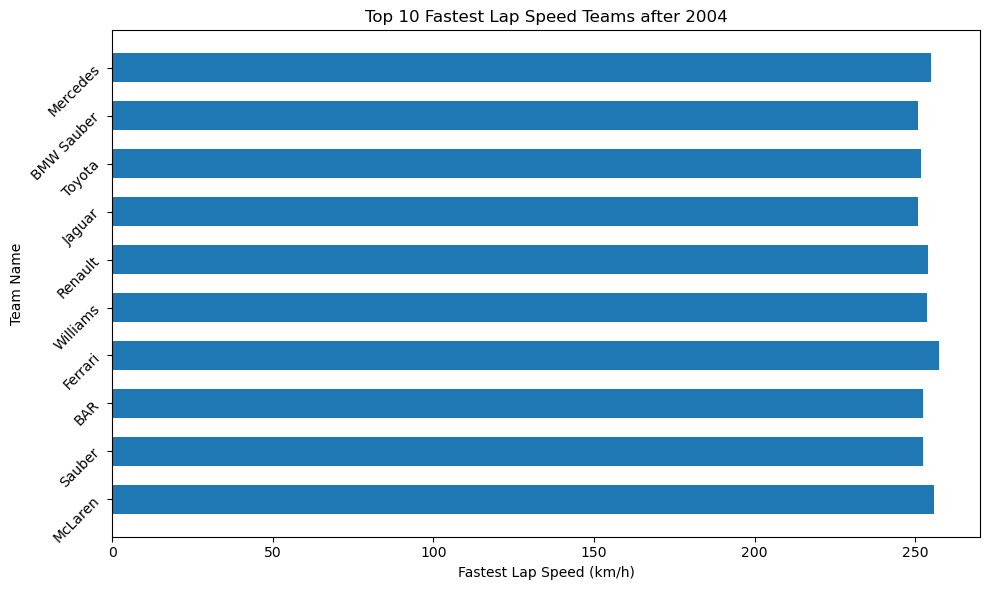

In [67]:
# Create a bar chart for top 3 teams with fastest lap speeds from 2004
plt.figure(figsize=(10, 6))
plt.barh(final_merged_top_30_df['Team Name'], final_merged_top_30_df['fastestLapSpeed'], height=0.6)
plt.xlabel('Fastest Lap Speed (km/h)')
plt.ylabel('Team Name')
plt.title('Top 10 Fastest Lap Speed Teams after 2004')
plt.yticks(rotation=45)
plt.tight_layout()

# Show the chart
plt.show()

In [68]:
# #obtaining fastest speeds over average after 2004
final_merged_top_10_df = final_merged_df.loc[(final_merged_df["fastestLapSpeed"] >= 252.604),:]
final_merged_top_10_df.head()

,raceId,year,country,location,Circuit Name,Team Name,driverId,driver name,position,wins,fastestLapSpeed
29,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Ferrari,30.0,Michael Schumacher,2.0,12,256.324
30,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Ferrari,22.0,Rubens Barrichello,1.0,1,257.320
51,104.0,2004.0,Italy,Monza,Autodromo Nazionale di Monza,Williams,42.0,Antônio Pizzonia,7.0,0,253.566
157,85.0,2005.0,Italy,Monza,Autodromo Nazionale di Monza,Renault,4.0,Fernando Alonso,2.0,6,253.874
193,85.0,2005.0,Italy,Monza,Autodromo Nazionale di Monza,McLaren,31.0,Juan Pablo Montoya,1.0,2,254.861


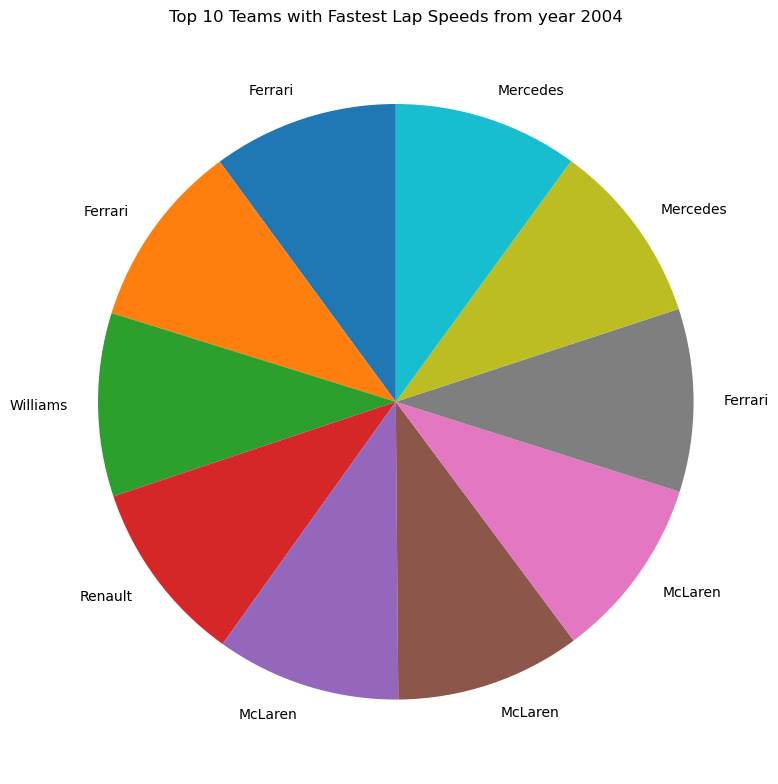

In [69]:
# Create a pie chart for top winners with fastest lap speeds per year from 2004
# I want to also show driver name and top speed??????????????????????????
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(final_merged_top_10_df['fastestLapSpeed'], labels=(final_merged_top_10_df['Team Name']), startangle=90)

ax.set_title('Top 10 Teams with Fastest Lap Speeds from year 2004')

plt.axis()  

plt.tight_layout()
plt.show()

R squared: 0.3632345751470929


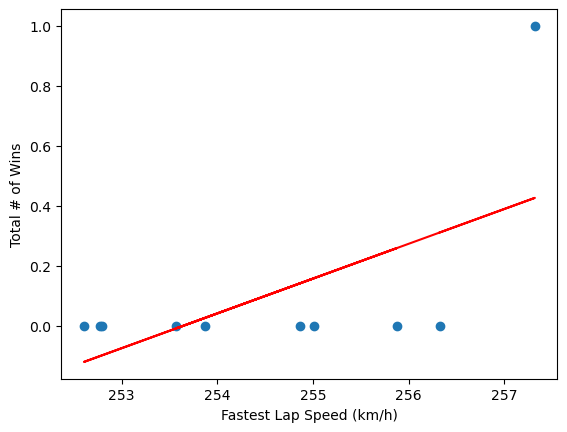

In [70]:
# storing position and fastest lap speed as x and y values
# can you check if this is correct wins = 1???????????????????????/
x_values = final_merged_top_10_df["fastestLapSpeed"]
y_values = (final_merged_top_10_df["wins"] == 1)

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Fastest Lap Speed (km/h)')
plt.ylabel('Total # of Wins')

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

R squared: 0.0014657302612203365


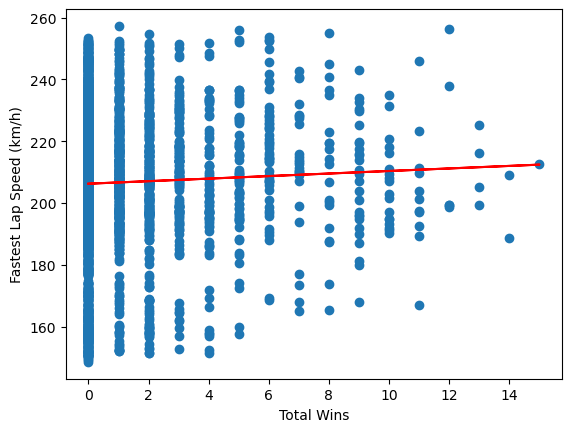

In [71]:
# storing position and fastest lap speed as x and y values
# not comfortable with result, I want to take wins with = 1????????????????????????????????
#x_values = (final_merged_df["wins"] >= 1)
x_values = final_merged_df["wins"]
y_values = final_merged_df["fastestLapSpeed"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Total Wins')
plt.ylabel('Fastest Lap Speed (km/h)')

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()

R squared: 0.0011852167003829535


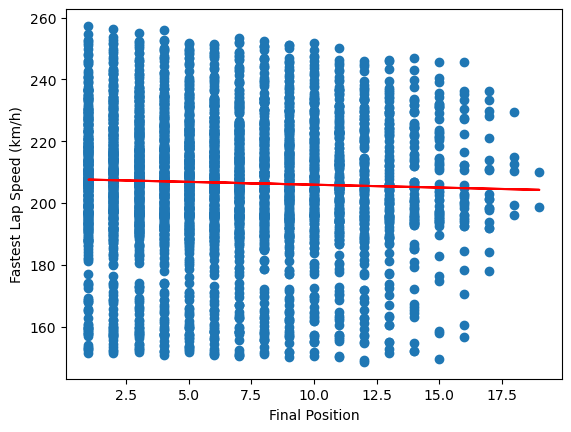

In [72]:
# storing position and fastest lap speed as x and y values
x_values = final_merged_df["position"]
y_values = final_merged_df["fastestLapSpeed"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Final Position')
plt.ylabel('Fastest Lap Speed (km/h)')

# Print r square value
print(f"R squared: {rvalue**2}")

# Show plot
plt.show()